In [1]:
# Based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynbimport torch
from torch.autograd import Variable

from torchvision.datasets import MNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [3]:
def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()
get_flatten_output()

torch.Size([2, 3200])

In [4]:
def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()
get_reshape_output()

torch.Size([2, 1, 28, 28])

In [5]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    

In [6]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [7]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [8]:
model = Model(2)

In [9]:
z, x_reconstructed = model(Variable(torch.rand(1,1,28,28)))
z.size(), x_reconstructed.size()

(torch.Size([1, 2]), torch.Size([1, 1, 28, 28]))

In [10]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def train(
    dataloader,
    z_dim=2,
    n_epochs=10,
    use_cuda=True,
    print_every=100,
    plot_every=500
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    #print(model)
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            mmd = compute_mmd(true_samples, z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + mmd
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
                    nll.data[0], mmd.data[0]))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model

In [11]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Negative log likelihood is 0.22640, mmd loss is 0.16098


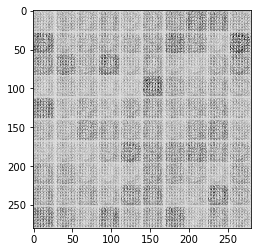

Negative log likelihood is 0.07079, mmd loss is 0.18036
Negative log likelihood is 0.06683, mmd loss is 0.14356
Negative log likelihood is 0.06666, mmd loss is 0.19137
Negative log likelihood is 0.05407, mmd loss is 0.01076
Negative log likelihood is 0.05390, mmd loss is 0.01516


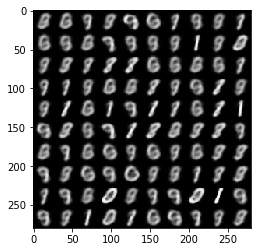

Negative log likelihood is 0.05003, mmd loss is 0.00209
Negative log likelihood is 0.05101, mmd loss is 0.00327
Negative log likelihood is 0.04613, mmd loss is 0.01145
Negative log likelihood is 0.04718, mmd loss is 0.00600
Negative log likelihood is 0.04580, mmd loss is 0.00435


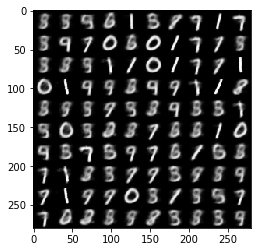

Negative log likelihood is 0.04828, mmd loss is 0.00371
Negative log likelihood is 0.04477, mmd loss is 0.00735
Negative log likelihood is 0.04152, mmd loss is 0.01076
Negative log likelihood is 0.04294, mmd loss is 0.00531
Negative log likelihood is 0.04427, mmd loss is 0.00280


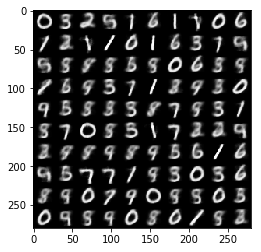

Negative log likelihood is 0.04037, mmd loss is 0.00263
Negative log likelihood is 0.04168, mmd loss is 0.00730
Negative log likelihood is 0.03984, mmd loss is 0.02068
Negative log likelihood is 0.04214, mmd loss is 0.00499
Negative log likelihood is 0.04301, mmd loss is 0.00165


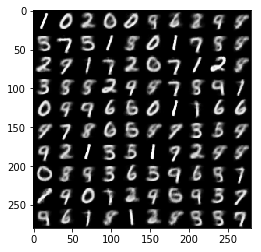

Negative log likelihood is 0.04224, mmd loss is 0.00758
Negative log likelihood is 0.04169, mmd loss is 0.00352
Negative log likelihood is 0.03888, mmd loss is 0.00322
Negative log likelihood is 0.03905, mmd loss is 0.00214
Negative log likelihood is 0.03961, mmd loss is 0.00555


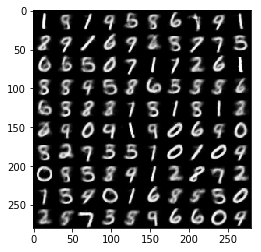

Negative log likelihood is 0.03900, mmd loss is 0.00179
Negative log likelihood is 0.03874, mmd loss is 0.00816
Negative log likelihood is 0.04035, mmd loss is 0.00718
Negative log likelihood is 0.03880, mmd loss is 0.00216


In [12]:
z_dim = 2
model = train(mnist_train, z_dim=z_dim, n_epochs=10)

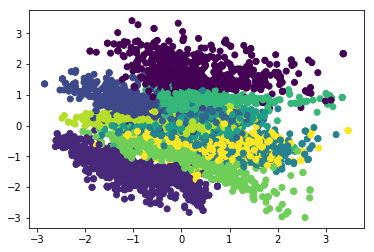

In [13]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()